In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import time

### Load Data

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Split Data

In [3]:
from sklearn.model_selection import train_test_split

iris_x = iris_df[iris_df.columns[:-1]].values
iris_y = iris_df[iris_df.columns[-1]].values
iris_y= pd.get_dummies(iris_y).values

x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_y, test_size=0.33, random_state=42)

In [4]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = x_train.shape[1]
print(f"numFeatures is: {numFeatures}")
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = y_train.shape[1]
print(f"numLabels is: {numLabels}")

numFeatures is: 4
numLabels is: 3


In [5]:
# Build a TF constant
x_train = tf.constant(x_train, dtype="float32")
y_train = tf.constant(y_train, dtype="float32")
x_test = tf.constant(x_test, dtype="float32")
y_test = tf.constant(y_test, dtype="float32")

### Logistic Regression NN Model

In [6]:
# Setting model weight and biases
# weight = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and 3-dimensional output
# bias = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

#Randomly sample from a normal distribution with standard deviation .01 to strat with a small number
weights = tf.Variable(tf.random.normal(shape=(numFeatures, numLabels), mean=0., stddev=0.01, name="weights"), dtype='float32')
bias = tf.Variable(tf.random.normal(shape=(1,numLabels), mean=0., stddev=0.01, name="bias"), dtype='float32')

weights, bias

(<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.00283736,  0.01040908, -0.00258463],
        [-0.01341241, -0.00772673,  0.00481529],
        [ 0.00232704, -0.00805105,  0.00244692],
        [ 0.00310837,  0.002429  ,  0.00492354]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[-0.01312229,  0.00333932,  0.01272079]], dtype=float32)>)

### Model Training

In [7]:
# Number of Epochs in our training
Epochs = 700

# Defining our learning rate iterations (decay)
# initial_learning_rate: This is the initial learning rate, which is set to 0.0008.
initial_learning_rate=0.0008
# decay_steps: The number of steps or epochs after which the learning rate will decay. 
#              In this case, it's set to x_train.shape[0], which means that the learning rate will decay after each epoch.
decay_steps=x_train.shape[0]
# decay_rate: The factor by which the learning rate will decay after decay_steps epochs. 
#             It's set to 0.95, meaning that the learning rate will be reduced by 5% after each decay_steps epochs.
decay_rate= 0.95
# staircase: If staircase is set to True, the learning rate will be reduced at discrete intervals, following a step-like pattern. 
#            If set to False, the decay will be continuous.
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate= decay_rate, 
    staircase=True
    )

# Defining the cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

In [8]:
# Logistic Regression Function
def logistic_regression(x):
    weights_OP = tf.matmul(x, weights, name="apply_weights")
    bias_OP = tf.add(weights_OP, bias, name="add_bias") 
    activation_OP = tf.nn.sigmoid(bias_OP, name="activation")
    return activation_OP

# Accuracy metric
def accuracy(y_pred, y_true):
# Predicted class is the index of the highest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimization process
def optimization(x, y):
    with tf.GradientTape() as tape:
        pred = logistic_regression(x) # Prediction
        loss = loss_object(pred, y) # MSE (Mean Squared Error)
    gradients = tape.gradient(loss, [weights, bias]) # Adjust the weight & bias
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [9]:
# Initialize reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1

# Training epochs
for i in range(Epochs):
    if i > 1 and diff < .0001:
        print(f"change in loss {diff}; convergence.")
        break
    else:
        # Run training step
        optimization(x_train, y_train)
        
        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            
            pred = logistic_regression(x_test)

            # Add loss to live graphing variable
            newLoss = loss_object(pred, y_test)
            loss_values.append(newLoss)
            
            # Generate accuracy stats on test data
            acc = accuracy(pred, y_test)
            accuracy_values.append(acc)
            
    
            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            # Generate print statements
            # print(f"step {i}, training accuracy {acc}, loss {newLoss}, change in loss {diff}")

# How well do we perform on held-out test data?
print(f"final accuracy on test set: {acc.numpy()}")

final accuracy on test set: 0.3199999928474426


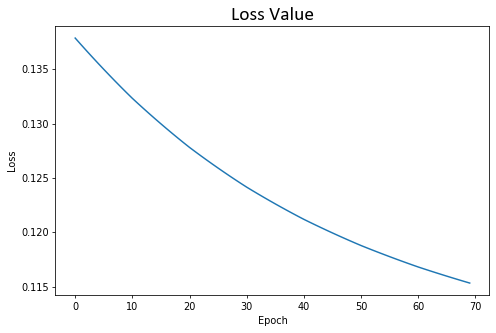

In [10]:
plt.figure(figsize = (8,5), dpi = 70)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.title("Loss Value", fontdict = {"fontname": "Calibri", "fontsize": 20})
plt.show()